/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


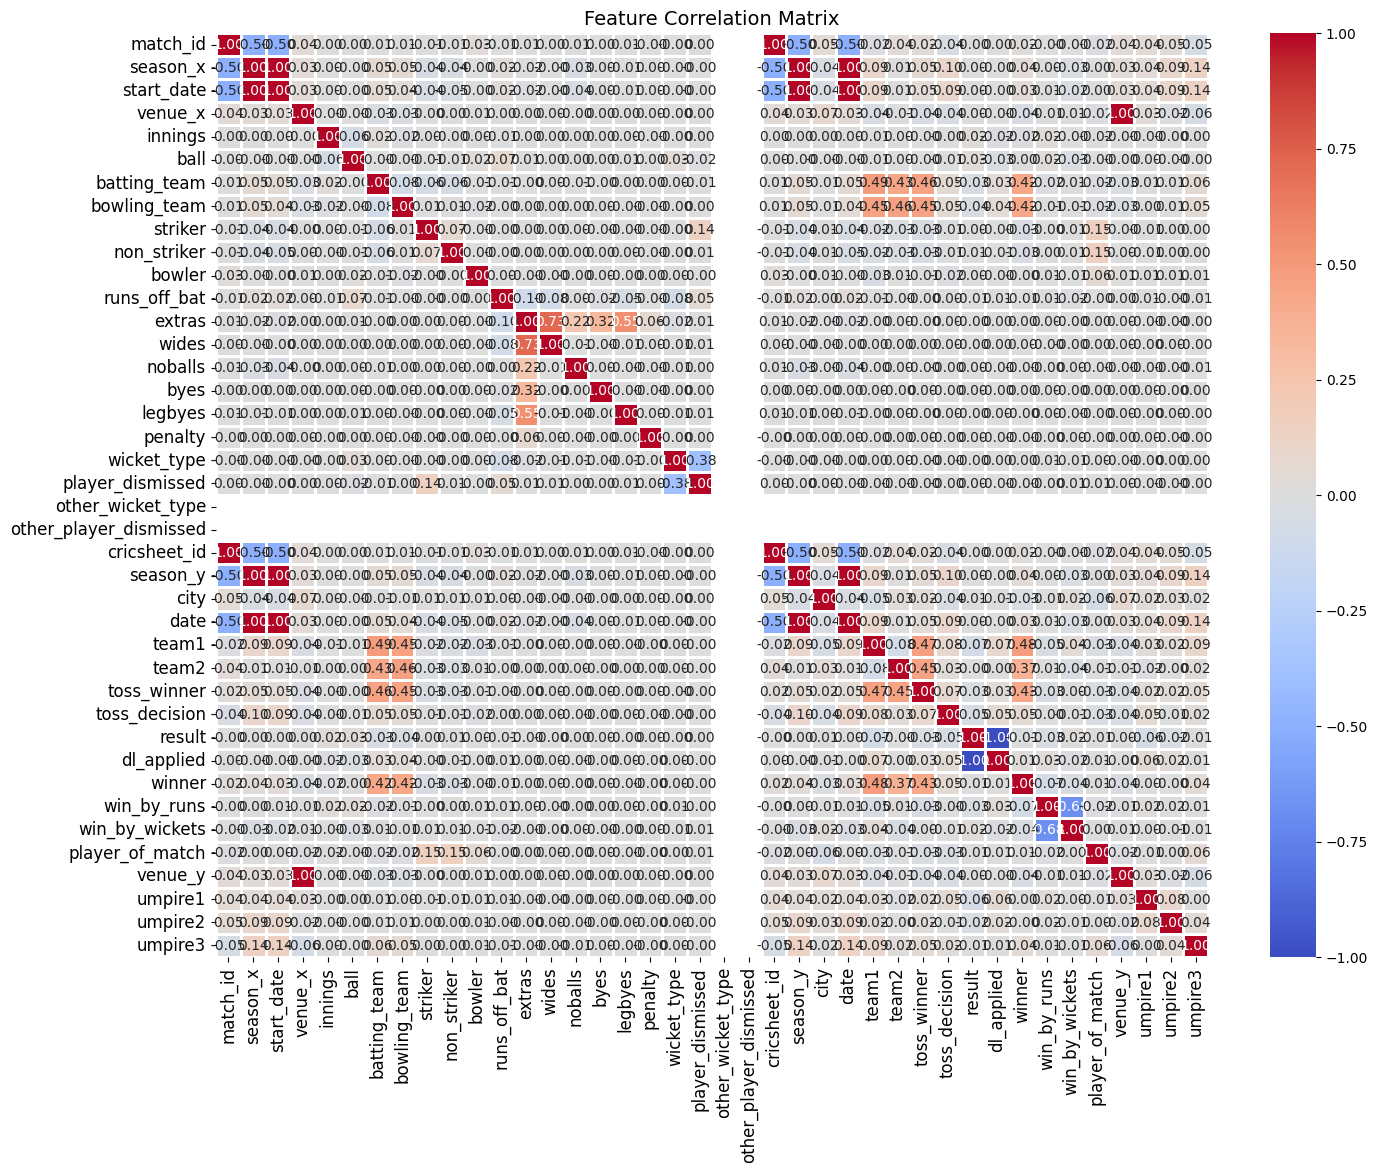

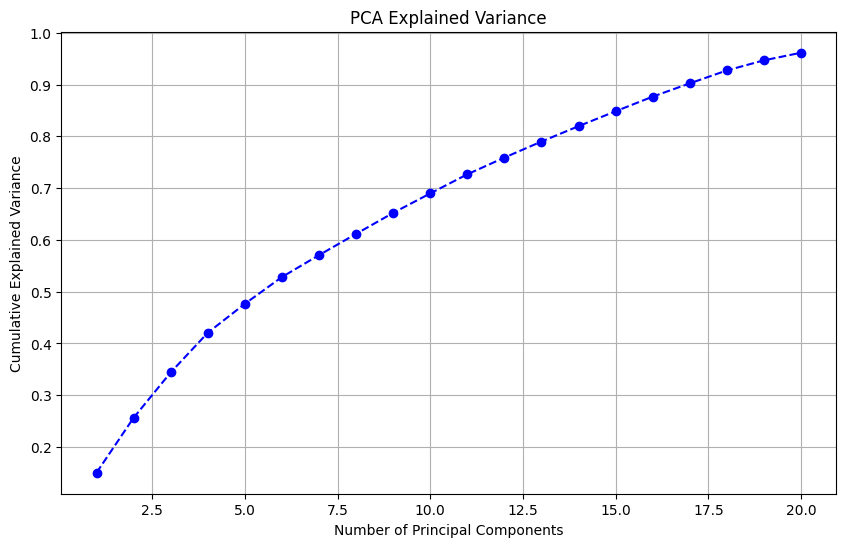

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
match_data_path = "/kaggle/input/odi-mini-project/ODI_Match_Data.csv"
match_info_path = "/kaggle/input/odi-mini-project/ODI_Match_info.csv"

df_match_data = pd.read_csv(match_data_path, dtype=str)
df_match_info = pd.read_csv(match_info_path, dtype=str)

# Merge datasets on match_id
if 'match_id' in df_match_data.columns and 'id' in df_match_info.columns:
    df_merged = df_match_data.merge(df_match_info, left_on='match_id', right_on='id', how='left')
    df_merged.drop(columns=['id'], inplace=True, errors='ignore')  # Drop redundant column
else:
    raise KeyError("Ensure 'match_id' exists in match data and 'id' exists in match info")

# Handling missing values
def fill_missing_values(df):
    fill_values = {
        'wides': 0, 'noballs': 0, 'byes': 0, 'legbyes': 0, 'penalty': 0,
        'wicket_type': 'Not Out', 'player_dismissed': 'None',
        'other_wicket_type': 'None', 'other_player_dismissed': 'None',
        'win_by_runs': 0, 'win_by_wickets': 0, 'player_of_match': 'Unknown'
    }
    df.fillna(fill_values, inplace=True)
    return df

df_merged = fill_missing_values(df_merged)

# Convert season column to numeric format
if 'season' in df_merged.columns:
    df_merged['season'] = df_merged['season'].astype(str).str.extract(r'(\d{4})')
    df_merged['season'] = pd.to_numeric(df_merged['season'], errors='coerce')
    df_merged['season'].fillna(df_merged['season'].median(), inplace=True)

# Encode categorical columns dynamically
label_encoders = {}
categorical_columns = df_merged.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    le = LabelEncoder()
    df_merged[col] = le.fit_transform(df_merged[col].astype(str))
    label_encoders[col] = le  # Store for inverse transformation if needed

# Replace infinite values and drop NaNs
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.dropna(inplace=True)

# Standardizing and Normalizing numerical features
numerical_columns = df_merged.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
df_merged[numerical_columns] = scaler.fit_transform(df_merged[numerical_columns])
df_merged[numerical_columns] = minmax_scaler.fit_transform(df_merged[numerical_columns])

# Optimized Correlation Matrix Plot
plt.figure(figsize=(16, 12))
corr_matrix = df_merged.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.75)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Feature Correlation Matrix", fontsize=14)
plt.show()

# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
df_pca = pca.fit_transform(df_merged[numerical_columns])

df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

# Save processed PCA data
df_pca.to_csv("/kaggle/working/processed_odi_pca_data.csv", index=False)

# PCA Variance Explained Plot
def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid()
    plt.show()

plot_pca_variance(pca)
